# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [51]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils_ as utils



In [52]:
import datetime
timestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
logdir = os.path.join('.', 'logdir', timestr)

## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


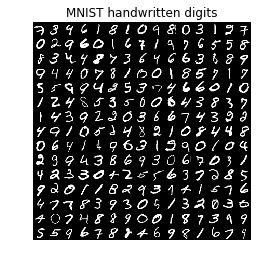

In [53]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)



## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [54]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


In [55]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
Flatten 	 (?, 3136)
denseOut	 (?, 10)
Model consits of  31786 trainable parameters.


In [56]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    tf.summary.FileWriter(os.path.join(logdir, '3EXE_1'), sess.graph)

In [57]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [58]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [9]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass


Begin training loop
Epoch 1 : Train Loss  0.083, Train acc  0.970,  Valid loss  0.137,  Valid acc  0.961
Epoch 2 : Train Loss  0.149, Train acc  0.960,  Valid loss  0.088,  Valid acc  0.974
Epoch 3 : Train Loss  0.016, Train acc  1.000,  Valid loss  0.073,  Valid acc  0.978
Epoch 4 : Train Loss  0.052, Train acc  0.980,  Valid loss  0.069,  Valid acc  0.979
Epoch 5 : Train Loss  0.025, Train acc  0.990,  Valid loss  0.058,  Valid acc  0.982
Epoch 6 : Train Loss  0.033, Train acc  1.000,  Valid loss  0.066,  Valid acc  0.980
Epoch 7 : Train Loss  0.061, Train acc  0.970,  Valid loss  0.062,  Valid acc  0.982
Epoch 8 : Train Loss  0.043, Train acc  0.990,  Valid loss  0.058,  Valid acc  0.983
Epoch 9 : Train Loss  0.011, Train acc  1.000,  Valid loss  0.055,  Valid acc  0.984
Epoch 10 : Train Loss  0.030, Train acc  0.980,  Valid loss  0.059,  Valid acc  0.982
Test Loss  0.053, Test acc  0.982


(<matplotlib.text.Text at 0x1c3b1e4ce48>,
 (0.75, 1.03))

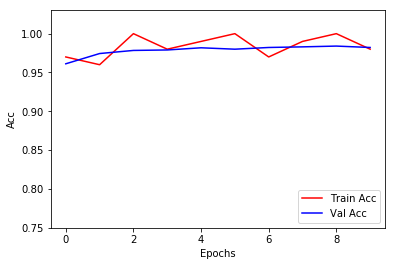

In [10]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments

#### <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

<span style="color:blue"> Answer: </span>





# 1:
First window:
$$ 2+6 = 8 $$
Second window:
$$ 2+1+4+4+9 = 20 $$
Third window:
$$ 2+4+2+6 = 14 $$
Fourth window:
$$ 4+2+6+4+9 = 25 $$
I.e. the 2x2 convolved feature is:
$$
Y = \begin{bmatrix}
       8 & 20  \\[0.3em]
       14 & 25    \\[0.3em]
     \end{bmatrix}
$$
# 2:
As the feature space currently is 2x2, the result of 2x2 max pooling w/o any zero padding is a scalar of 
$$ \textrm{max}(Y) = 25 $$
Zeropadding the feature space would give the following window:
$$
Y_0 = \begin{bmatrix}
    0 & 0 & 0 & 0 \\[0.3em]
    0 & 8 & 20 & 0  \\[0.3em]
    0 & 14 & 25 & 0    \\[0.3em]
    0 & 0 & 0 & 0
     \end{bmatrix}
$$
and by performing 2x2 max pooling with a stride of 2 would return the original feature space $ Y $


#### <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>

``` 
Paste your code here
```


``` 
Paste the trace of the tensors shape as it is propagated through the network here
```


# Importing/reloading data

In [46]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Building the model

In [48]:
tf.reset_default_graph()
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 32
kernel_size_2 = (3,3)
pool_size_2 = (2,2)

filters_3 = 16
kernel_size_3 = (3,3)
pool_size_3 = (8,8)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
        
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
with tf.variable_scope('convLayer3'):
    conv3 = Conv2D(filters_3, kernel_size_3, strides=(1,1), padding=padding, activation='relu')
    x = conv3(x)
    print('conv3 \t\t', x.get_shape())

    pool3 = MaxPooling2D(pool_size=pool_size_3, strides=None, padding=padding)
    x = pool3(x)
    print('pool3 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
conv2 		 (?, 14, 14, 32)
pool2 		 (?, 7, 7, 32)
conv3 		 (?, 7, 7, 16)
pool3 		 (?, 1, 1, 16)
Flatten 	 (?, 16)
denseOut	 (?, 10)
Model consits of  9850 trainable parameters.


# Defining training ops

In [49]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Training

In [50]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass


Begin training loop
Epoch 0 : Train Loss  2.306, Train acc  0.100,  Valid loss  2.303,  Valid acc  0.125
Epoch 1 : Train Loss  0.315, Train acc  0.900,  Valid loss  0.243,  Valid acc  0.932
Epoch 2 : Train Loss  0.208, Train acc  0.940,  Valid loss  0.156,  Valid acc  0.958
Epoch 3 : Train Loss  0.150, Train acc  0.960,  Valid loss  0.127,  Valid acc  0.964
Epoch 4 : Train Loss  0.129, Train acc  0.950,  Valid loss  0.107,  Valid acc  0.970
Epoch 5 : Train Loss  0.171, Train acc  0.950,  Valid loss  0.104,  Valid acc  0.970
Epoch 6 : Train Loss  0.055, Train acc  0.980,  Valid loss  0.092,  Valid acc  0.974
Epoch 7 : Train Loss  0.008, Train acc  1.000,  Valid loss  0.089,  Valid acc  0.973
Epoch 8 : Train Loss  0.087, Train acc  0.980,  Valid loss  0.097,  Valid acc  0.972
Epoch 9 : Train Loss  0.038, Train acc  0.980,  Valid loss  0.109,  Valid acc  0.969
Epoch 10 : Train Loss  0.032, Train acc  1.000,  Valid loss  0.075,  Valid acc  0.978
Test Loss  0.064, Test acc  0.980


(<matplotlib.text.Text at 0x244c5291470>,
 (0.75, 1.03))

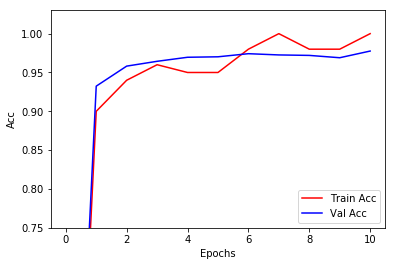

In [60]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

### So the number of parameters have been reduced from 31786 to 9850, and we still get a test accuracy 98% -  pretty good, hey! We simply introduced 3 layers with max pooling on all them to reduce the parameters.

#### <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>


# Reloading the model again

In [71]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

tf.reset_default_graph()
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 8
kernel_size_1 = (3,3)
pool_size_1 = (2,2)

filters_2 = 8
kernel_size_2 = (3,3)
pool_size_2 = (2,2)

filters_3 = 10
kernel_size_3 = (3,3)
pool_size_3 = (8,8)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('\nTrace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
        
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
with tf.variable_scope('convLayer3'):
    conv3 = Conv2D(filters_3, kernel_size_3, strides=(1,1), padding=padding, activation='relu')
    x = conv3(x)
    print('conv3 \t\t', x.get_shape())

    pool3 = MaxPooling2D(pool_size=pool_size_3, strides=None, padding=padding)
    x = pool3(x)
    print('pool3 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 8)
pool1 		 (?, 14, 14, 8)
conv2 		 (?, 14, 14, 8)
pool2 		 (?, 7, 7, 8)
conv3 		 (?, 7, 7, 10)
pool3 		 (?, 1, 1, 10)
Flatten 	 (?, 10)
denseOut	 (?, 10)
Model consits of  1504 trainable parameters.


Begin training loop
Epoch 0 : Train Loss  2.307, Train acc  0.120,  Valid loss  2.316,  Valid acc  0.110
Epoch 1 : Train Loss  0.686, Train acc  0.750,  Valid loss  0.574,  Valid acc  0.824
Epoch 2 : Train Loss  0.410, Train acc  0.900,  Valid loss  0.402,  Valid acc  0.877
Epoch 3 : Train Loss  0.471, Train acc  0.850,  Valid loss  0.331,  Valid acc  0.902
Epoch 4 : Train Loss  0.299, Train acc  0.920,  Valid loss  0.286,  Valid acc  0.913
Epoch 5 : Train Loss  0.183, Train acc  0.910,  Valid loss  0.269,  Valid acc  0.920
Epoch 6 : Train Loss  0.311, Train acc  0.890,  Valid loss  0.240,  Valid acc  0.926
Epoch 7 : Train Loss  0.272, Train acc  0.940,  Valid loss  0.225,  Valid acc  0.933
Epoch 8 : Train Loss  0.240, Train acc  0.920,  Valid loss  0.216,  Valid acc  0.933
Epoch 9 : Train Loss  0.130, Train acc  0.950,  Valid loss  0.198,  Valid acc  0.941
Epoch 10 : Train Loss  0.148, Train acc  0.960,  Valid loss  0.213,  Valid acc  0.935
Test Loss  0.220, Test acc  0.933


(<matplotlib.text.Text at 0x244c513cb70>,
 (0.5, 1.03))

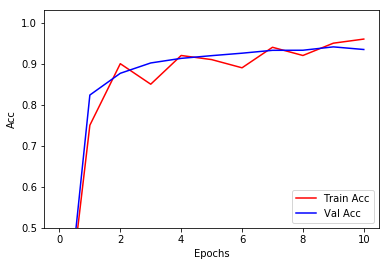

In [72]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass
    
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.5,1.03])

### 1504 parameters and test accuracy of 93.3% - amazing!

#### <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

<span style="color:blue"> Describe your findings: </span>


# Reload data again

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=True, # Don't flatten the images to vectors
                                      )


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


# Building a model

In [9]:
model = None
session = K.get_session()

if model is not None:
    model.reset_states() # Reset graph


# We use the exact same parameters as out implementation in Tensorflow
num_features = height*width
num_classes = 10
num_neurons = 2
num_layers = 1
batch_size = 100
num_epochs = 50

# We define a sequential model which simply stack layers on top of each other sequentially
model = Sequential()

# The first layer needs to know the input_dim, so it is handled separately
print('Creating layer', 0)
model.add(Dense(units=num_neurons, input_dim=num_features))
# Then we add a Relu activation function
model.add(Activation('relu'))

# We can now easily create as many layers as we want!
for i in range(1, num_layers):
    print('Creating layer', i)
    model.add(Dense(units=num_neurons, activation='relu'))

# then we add a new Dense layer with the size of our 10 classes 
print('Creating output layer')
model.add(Dense(units=num_classes))

# Finally we add a softmax activation function in order to transform the output into a propability distribution
model.add(Activation('softmax'))

# create adam optimizer
adam = keras.optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# We then transform the model into a tensorflow graph and use adam optimizer and cross entropy as our loss
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

Creating layer 0
Creating output layer


In [3]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 1570      
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________
None


# Training

In [10]:
train_history = model.fit(mnist_data.train.images, mnist_data.train.labels,
          validation_data = (mnist_data.test.images, mnist_data.test.labels),
          epochs=num_epochs, 
          batch_size=batch_size)

Train on 55000 samples, validate on 10000 samples
Epoch 1/50
55000/55000 [==============================] - 1s - loss: 1.7944 - acc: 0.3437 - val_loss: 1.5276 - val_acc: 0.4190
Epoch 2/50
55000/55000 [==============================] - 1s - loss: 1.4275 - acc: 0.4759 - val_loss: 1.3325 - val_acc: 0.5336
Epoch 3/50
55000/55000 [==============================] - 1s - loss: 1.2885 - acc: 0.5492 - val_loss: 1.2297 - val_acc: 0.5647
Epoch 4/50
55000/55000 [==============================] - 1s - loss: 1.2100 - acc: 0.5712 - val_loss: 1.1764 - val_acc: 0.5841
Epoch 5/50
55000/55000 [==============================] - 1s - loss: 1.1648 - acc: 0.5844 - val_loss: 1.1425 - val_acc: 0.5970
Epoch 6/50
55000/55000 [==============================] - 1s - loss: 1.1354 - acc: 0.5947 - val_loss: 1.1216 - val_acc: 0.6030
Epoch 7/50
55000/55000 [==============================] - 1s - loss: 1.1143 - acc: 0.6036 - val_loss: 1.1046 - val_acc: 0.6092
Epoch 8/50
55000/55000 [==============================] - 1s 

In [12]:
loss, accuracy = model.evaluate(mnist_data.test.images, 
                                mnist_data.test.labels, 
                                batch_size=128)
print()
print('Test Loss:', loss)
print('Test Accuracy', accuracy)

 9472/10000 [===========================>..] - ETA: 0s
Test Loss: 0.96565810442
Test Accuracy 0.6886


### in conclusion the test accuracy with the dense FF net is 68.86% with 1600 params. The CNN with 1504 params scores 93.3%.

# Book exercise
## Sigmoid neurons simulating perceptrons, part II

Similar to part 1 (see below), the sigmoid function will move towards a step function by letting
$$ c \rightarrow \inf $$ 
The ultimate case of a sigmoid function must be the step function. 

However for 
$$z = 0$$ 
the output is $0.5$ as 
$$ exp(0) = 1$$ 
which yields 
$$1/(1+1) = 0.5$$

### Part I
The weight and biases for a net is defined as
$$z = wx + b$$
and the sigmoid function as
$$\frac{1}{1+e^{-z}}$$
By adding a constant such that
$$ z = cwx + cb, \quad c>0$$
the slope of the sigmoid will be steeper - take more "extreme" values so to say. This also means that if the output of the sigmoid function is less than 0.5 it will converge towards 0 by adder a higher c value, and vice versa. So the output of the perceptrons will change but the behavior of the network will not.